In [1]:
# Module path additions
import sys
import os.path as path
module_path = path.abspath("../modules")
if not module_path in sys.path:
    sys.path.append(module_path)


# Imports and data loading
from stopandglow.data import *
from stopandglow.processing.fitter.spherical import SHFitter
from sng_eval import *
import os
import logging as log

import numpy as np
import cv2 as cv
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt

# Init logging
log.basicConfig(level='INFO', format='[%(levelname)s] %(message)s')

[Taichi] version 1.7.0, llvm 15.0.4, commit 2fd24490, linux, python 3.11.9


[I 05/23/24 13:12:08.685 90097] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
/home/god/Raumfisch/Dev/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define dataset
SEQUENCE_NAME = "0422_pflanze"
CALIBRATION_NAME = "lightdome.json"

# Load data
dataset_path = os.path.join(os.path.abspath("./data/capture"), SEQUENCE_NAME)
calibration_path = os.path.join(os.path.abspath("./data/calibration"), CALIBRATION_NAME)

SEQ = Sequence()
SEQ.loadFolder(dataset_path)
CAL = Calibration(calibration_path)
LPSEQ = LpSequence(SEQ, CAL)

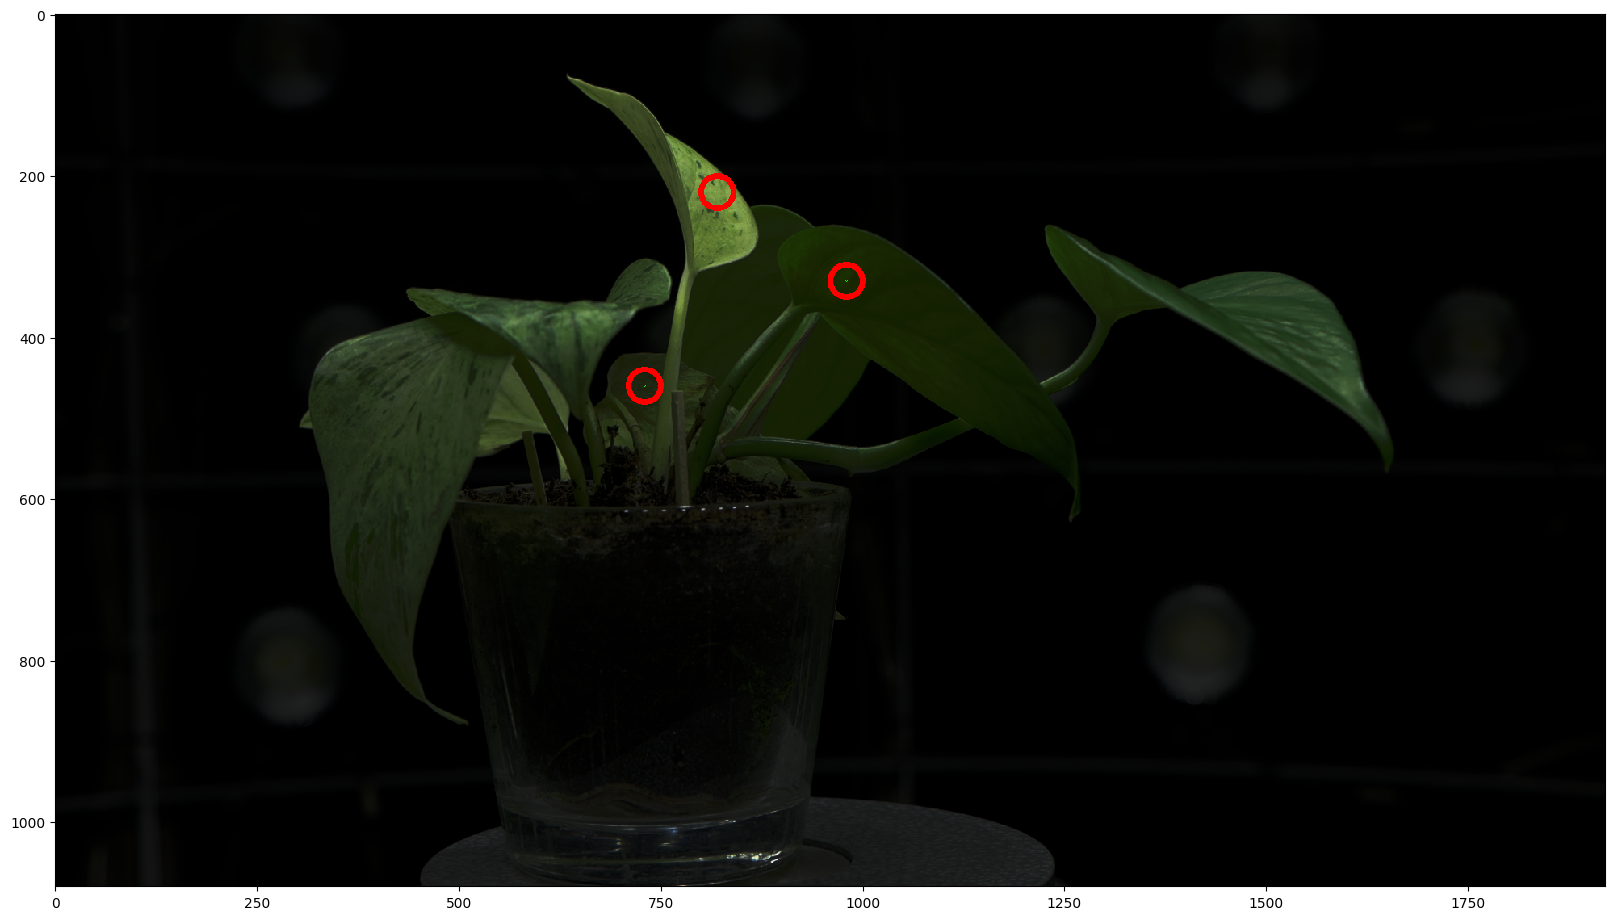

In [3]:
# Define Pixel coordinate (y, x) to plot data for
PIXEL_COORDS = (
    ([820, 220],  'Leaf Top'),
    ([980, 330], 'Leaf Mid'),
    ([730, 460],  'Leaf Bottom'),
)

PIXEL_ROTATION = [3,1,3,3]

# Get preview and show coordinate
img = SEQ.getPreview().asDomain(ImgDomain.sRGB, no_taich=True).asInt().get()
for coord, _ in PIXEL_COORDS:
    img = cv.circle(img, coord, 20, [255,0,0], 5)
    img = cv.circle(img, coord, 1, [0,255,0], 1)

plt.figure(figsize=(20,20)) # New big figure
#plt.subplot(1,1,1) 
plt.imshow(img, interpolation='nearest')


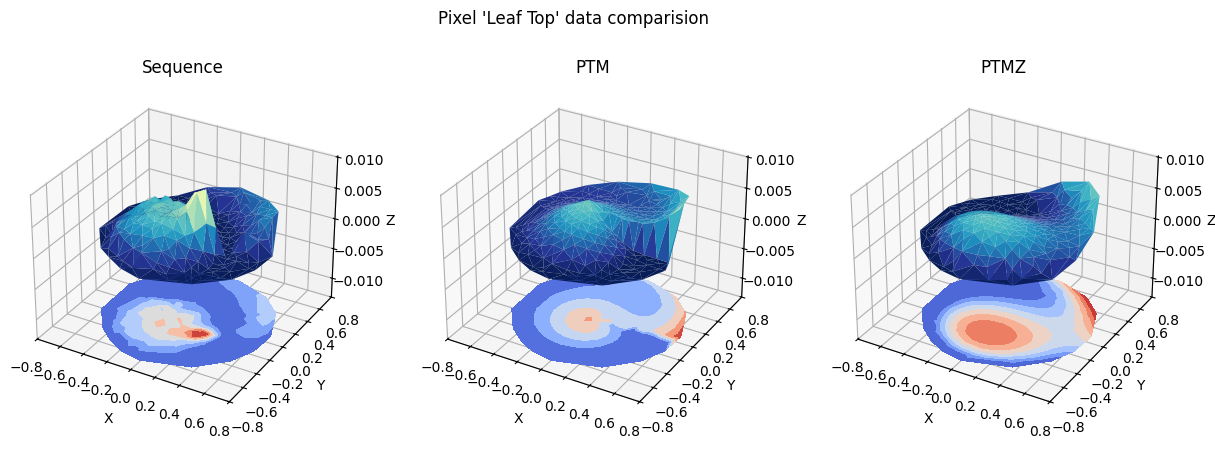

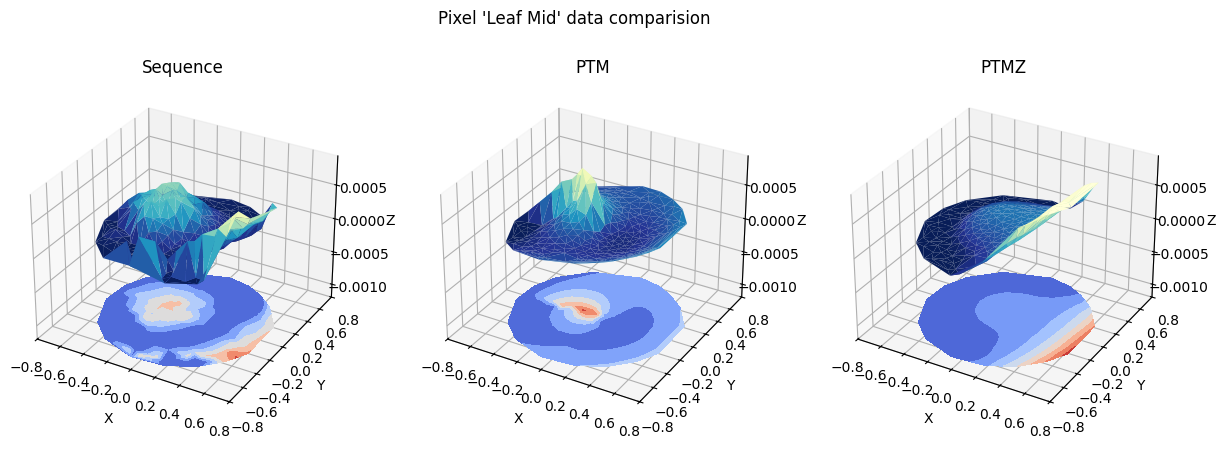

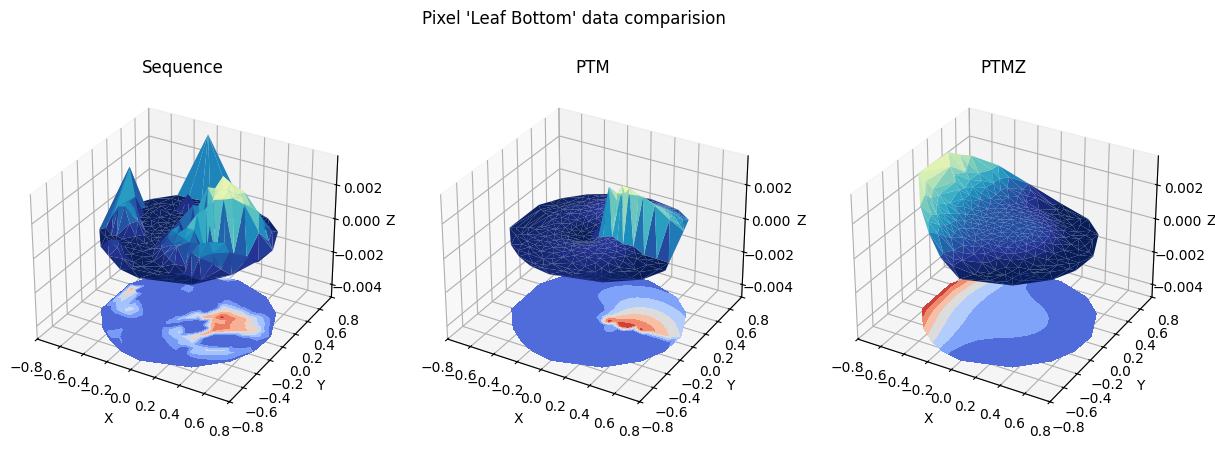

In [4]:
## Sequence, PTM & PTMZ comparision

# Sample sequence
seq_data = [sampleSeqData(LPSEQ, PIXEL_COORDS[i][0], rotation_steps=PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]

# Sample PTM & PTMZ
ptm_data = [sampleRtiData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptm')), CAL, CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
ptmz_data = [sampleRtiData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptmz')), CAL, CoordSys.ZVec, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]

# Plot
for i in range(len(seq_data)):
    fig, axs = plt.subplots(ncols=3, figsize=(15,5), subplot_kw={'projection': '3d'}) # nrows=1
    fig.suptitle(f"Pixel '{PIXEL_COORDS[i][1]}' data comparision")
    plotPointData(seq_data[i], normalize=False, ax=axs[0], title="Sequence")
    max_val = np.max(seq_data[i][2])
    plotPointData(ptm_data[i], normalize=max_val, ax=axs[1], title="PTM")
    plotPointData(ptmz_data[i], normalize=max_val, ax=axs[2], title="PTMZ")
    plt.show()


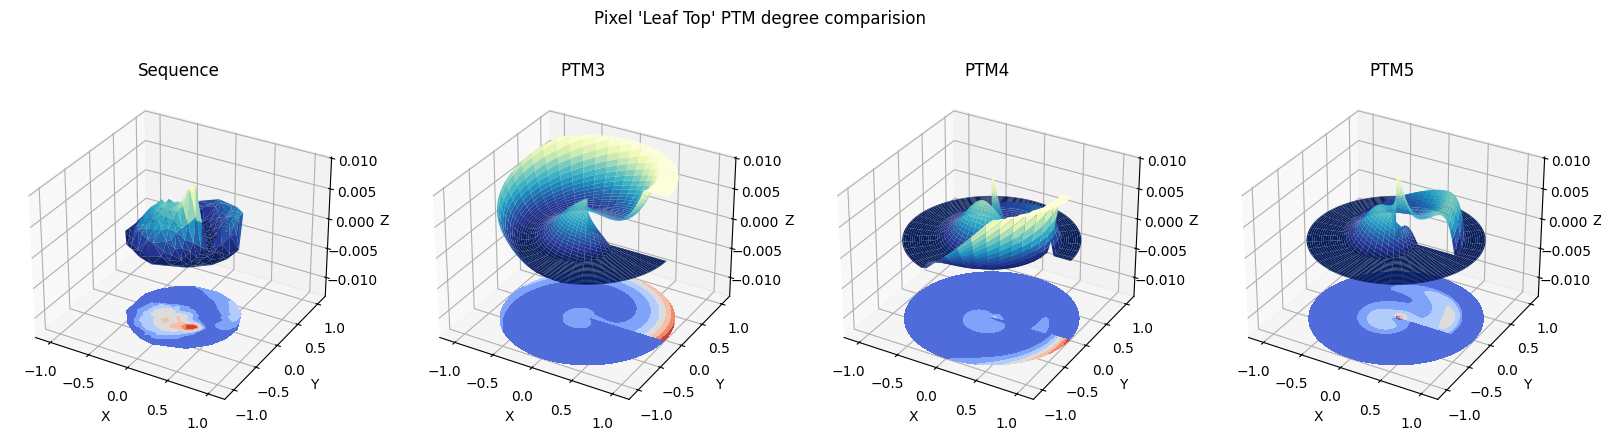

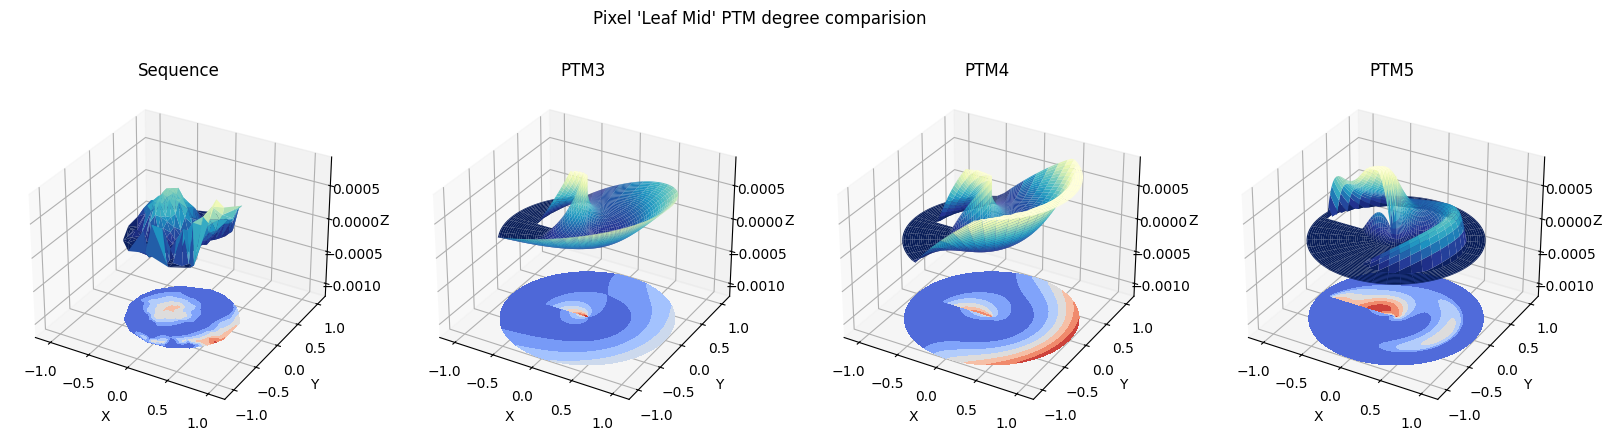

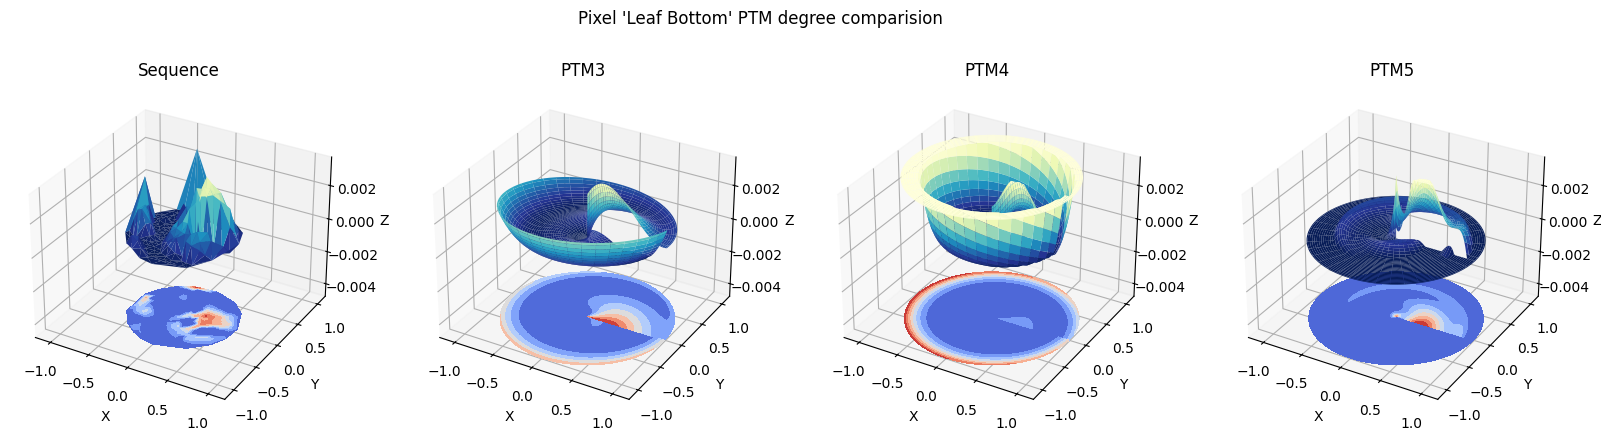

In [5]:
## PTM degrees

# Sample PTM degrees
ptm3_griddata = [sampleRtiGridData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptm')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
ptm4_griddata = [sampleRtiGridData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptm4')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
ptm5_griddata = [sampleRtiGridData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptm5')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]

# Plot
for i in range(len(seq_data)):
    fig, axs = plt.subplots(ncols=4, figsize=(20,5), subplot_kw={'projection': '3d'}) # nrows=1
    fig.suptitle(f"Pixel '{PIXEL_COORDS[i][1]}' PTM degree comparision")
    plotPointData(seq_data[i], normalize=False, trisurf_small=True, ax=axs[0], title="Sequence")
    max_val = np.max(seq_data[i][2])
    plotGridData(ptm3_griddata[i], normalize=max_val, ax=axs[1], title="PTM3")
    plotGridData(ptm4_griddata[i], normalize=max_val, ax=axs[2], title="PTM4")
    plotGridData(ptm5_griddata[i], normalize=max_val, ax=axs[3], title="PTM5")
    plt.show()


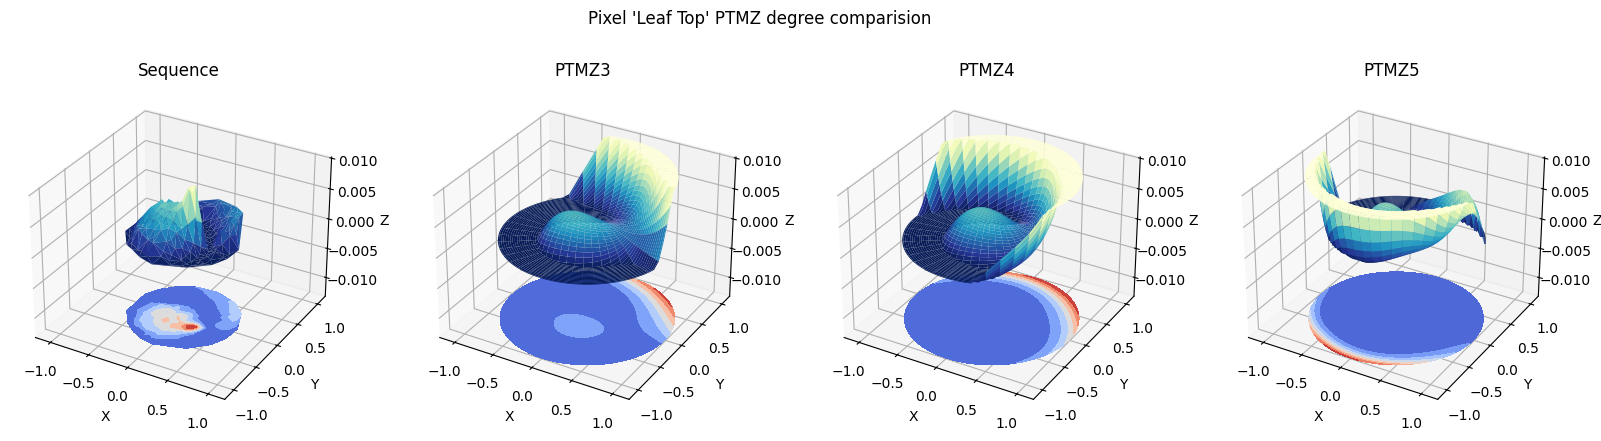

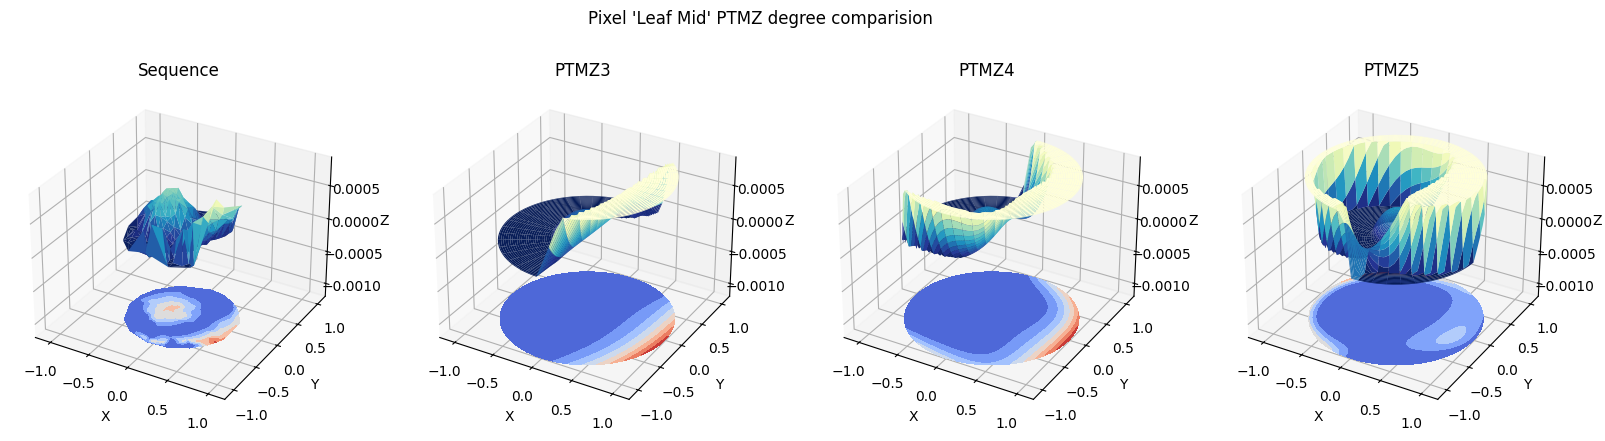

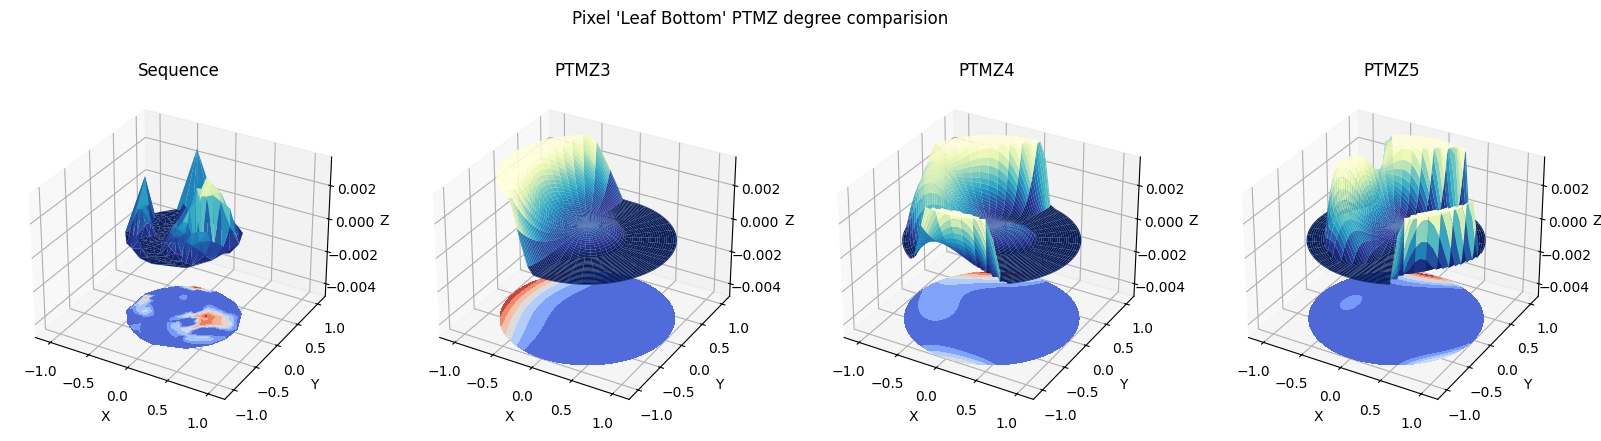

In [6]:
## PTMZ degrees

# Sample PTM degrees
ptmz3_griddata = [sampleRtiGridData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptmz')), CoordSys.ZVec, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
ptmz4_griddata = [sampleRtiGridData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptmz4')), CoordSys.ZVec, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
ptmz5_griddata = [sampleRtiGridData(lambda coord: calcPtm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('ptmz5')), CoordSys.ZVec, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]

# Plot
for i in range(len(seq_data)):
    fig, axs = plt.subplots(ncols=4, figsize=(20,5), subplot_kw={'projection': '3d'}) # nrows=1
    fig.suptitle(f"Pixel '{PIXEL_COORDS[i][1]}' PTMZ degree comparision")
    plotPointData(seq_data[i], normalize=False, trisurf_small=True, ax=axs[0], title="Sequence")
    max_val = np.max(seq_data[i][2])
    plotGridData(ptmz3_griddata[i], normalize=max_val, ax=axs[1], title="PTMZ3")
    plotGridData(ptmz4_griddata[i], normalize=max_val, ax=axs[2], title="PTMZ4")
    plotGridData(ptmz5_griddata[i], normalize=max_val, ax=axs[3], title="PTMZ5")
    plt.show()


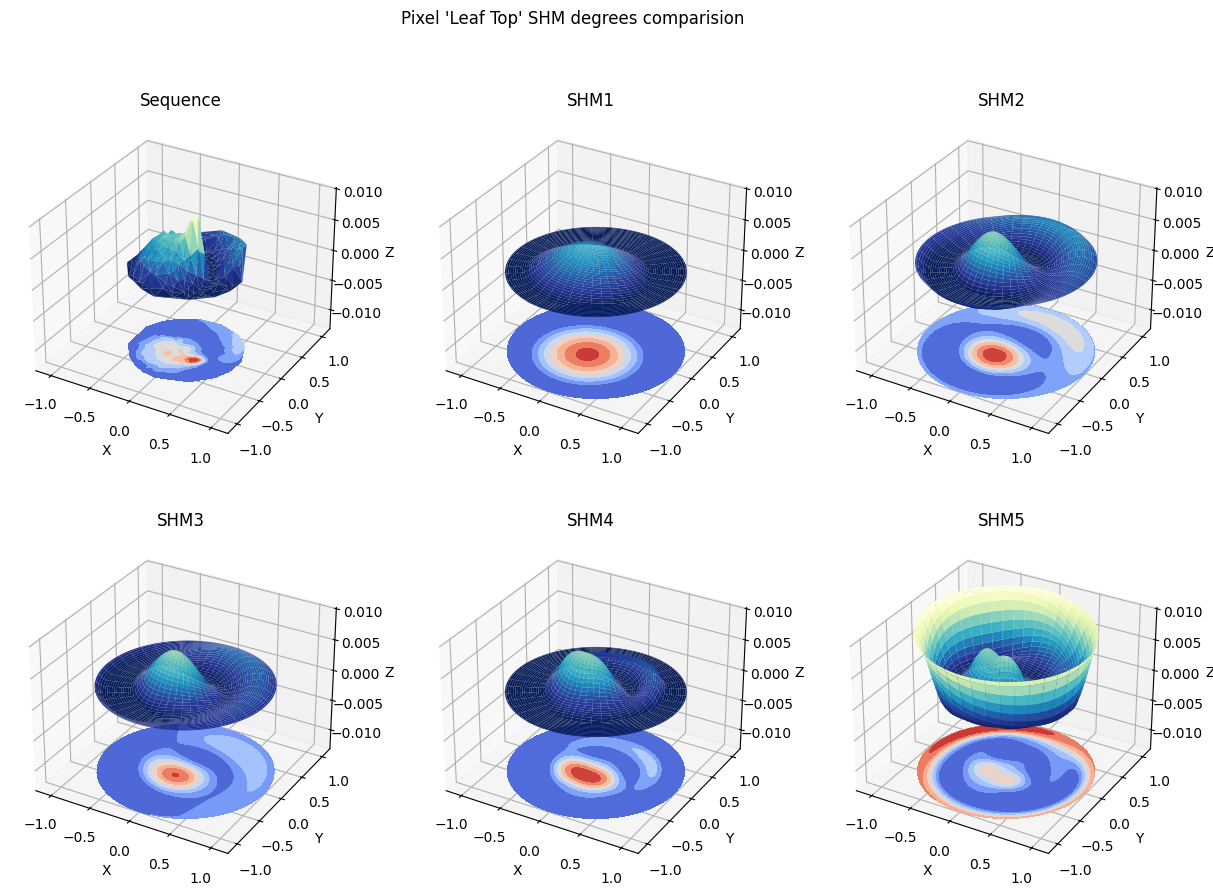

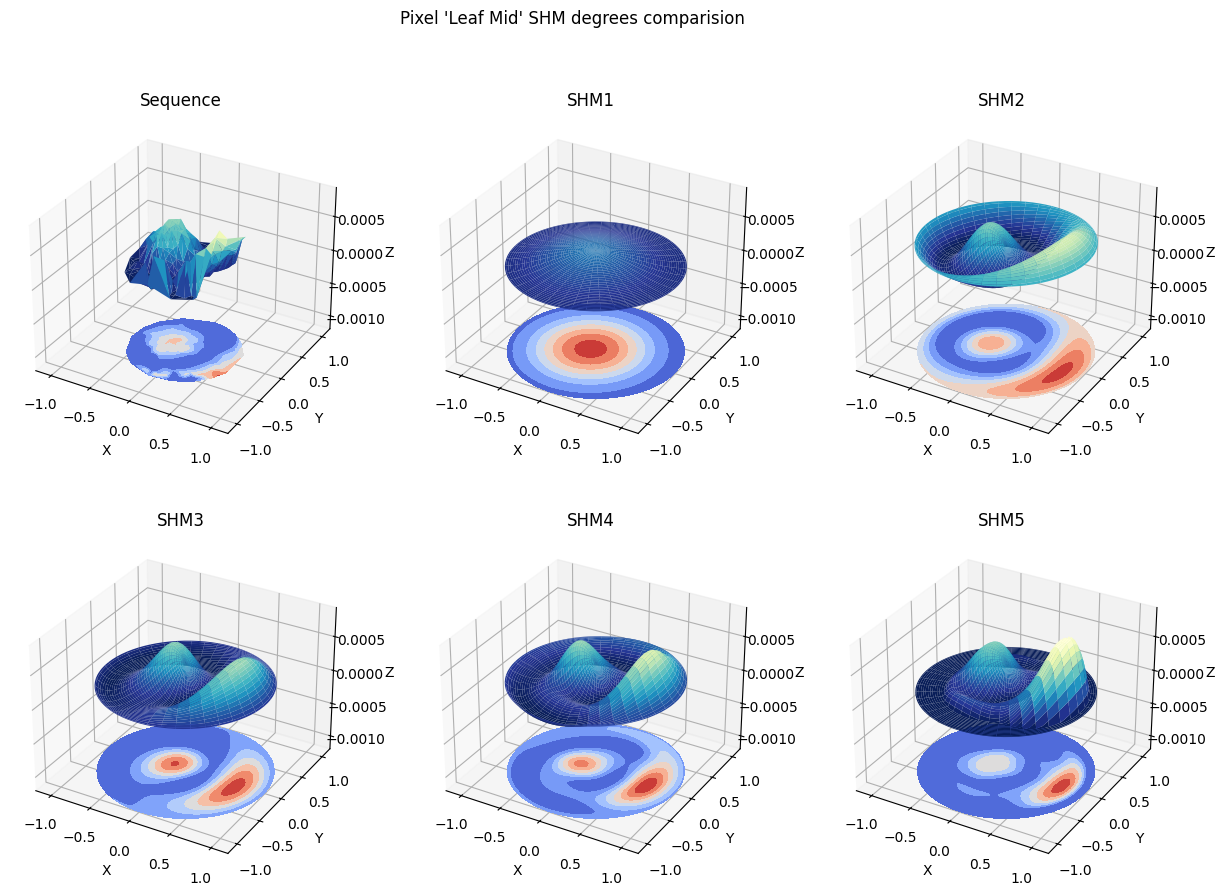

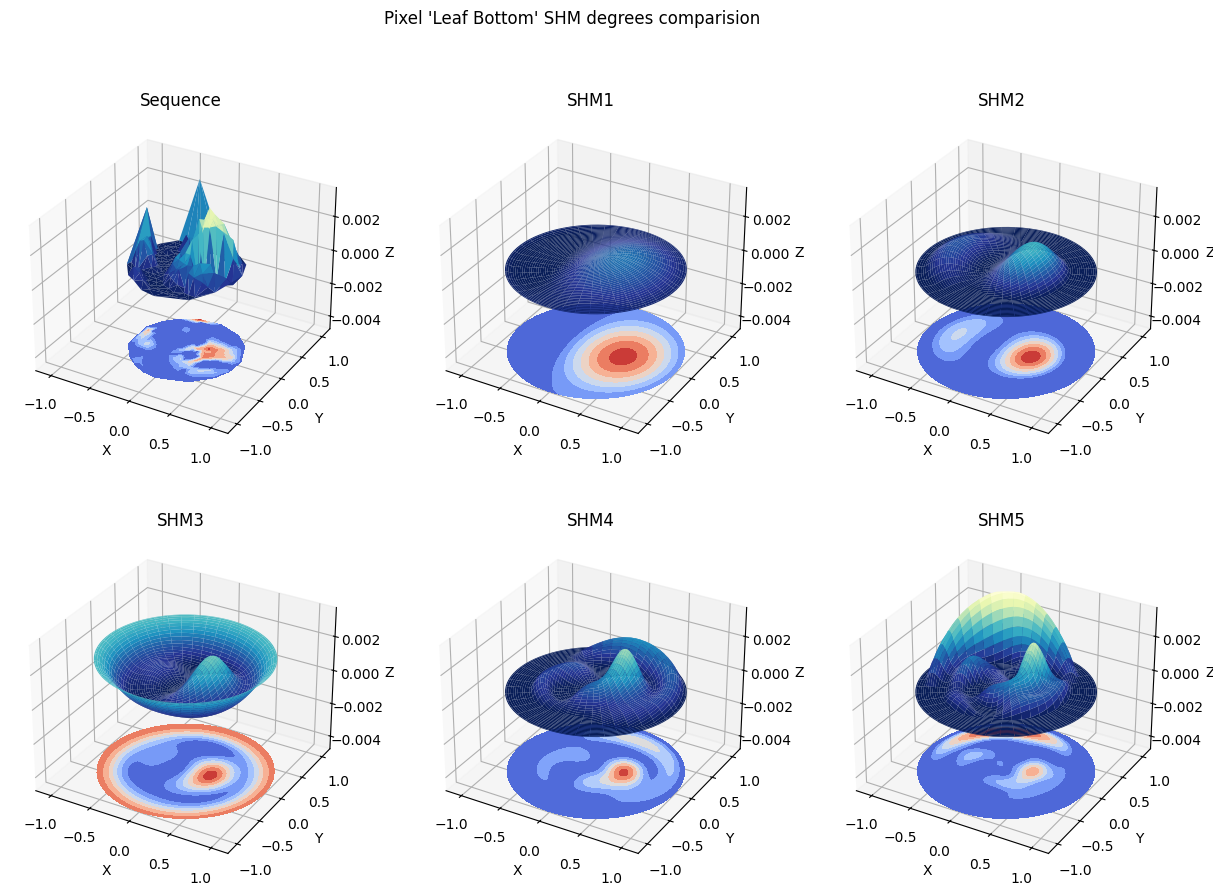

In [7]:
## Sequence, SHM, PTM? comparision

# Sample PTM & PTMZ
shm1_data = [sampleRtiGridData(lambda coord: calcShm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('shm')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm2_data = [sampleRtiGridData(lambda coord: calcShm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('shm2')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm3_data = [sampleRtiGridData(lambda coord: calcShm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('shm3')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm4_data = [sampleRtiGridData(lambda coord: calcShm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('shm4')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm5_data = [sampleRtiGridData(lambda coord: calcShm(coord, PIXEL_COORDS[i][0], SEQ.getDataSequence('shm5')), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
# Plot
for i in range(len(seq_data)):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10), subplot_kw={'projection': '3d'}) # nrows=1
    fig.suptitle(f"Pixel '{PIXEL_COORDS[i][1]}' SHM degrees comparision")
    plotPointData(seq_data[i], normalize=False, trisurf_small=True, ax=axs[0][0], title="Sequence")
    max_val = np.max(seq_data[i][2])
    plotGridData(shm1_data[i], normalize=max_val, clip=True, ax=axs[0][1], title="SHM1")
    plotGridData(shm2_data[i], normalize=max_val, clip=True, ax=axs[0][2], title="SHM2")
    plotGridData(shm3_data[i], normalize=max_val, clip=True, ax=axs[1][0], title="SHM3")
    plotGridData(shm4_data[i], normalize=max_val, clip=True, ax=axs[1][1], title="SHM4")
    plotGridData(shm5_data[i], normalize=max_val, clip=True, ax=axs[1][2], title="SHM5")
    plt.show()

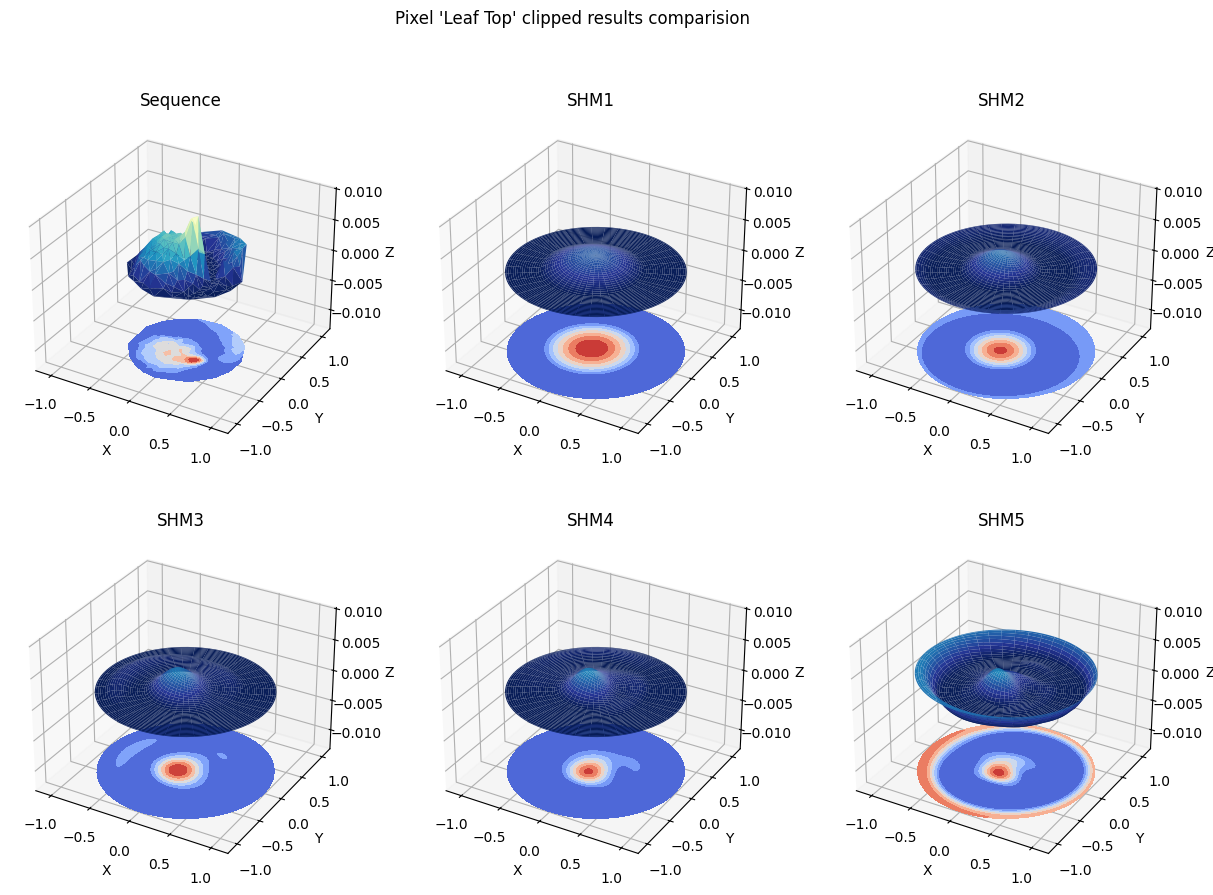

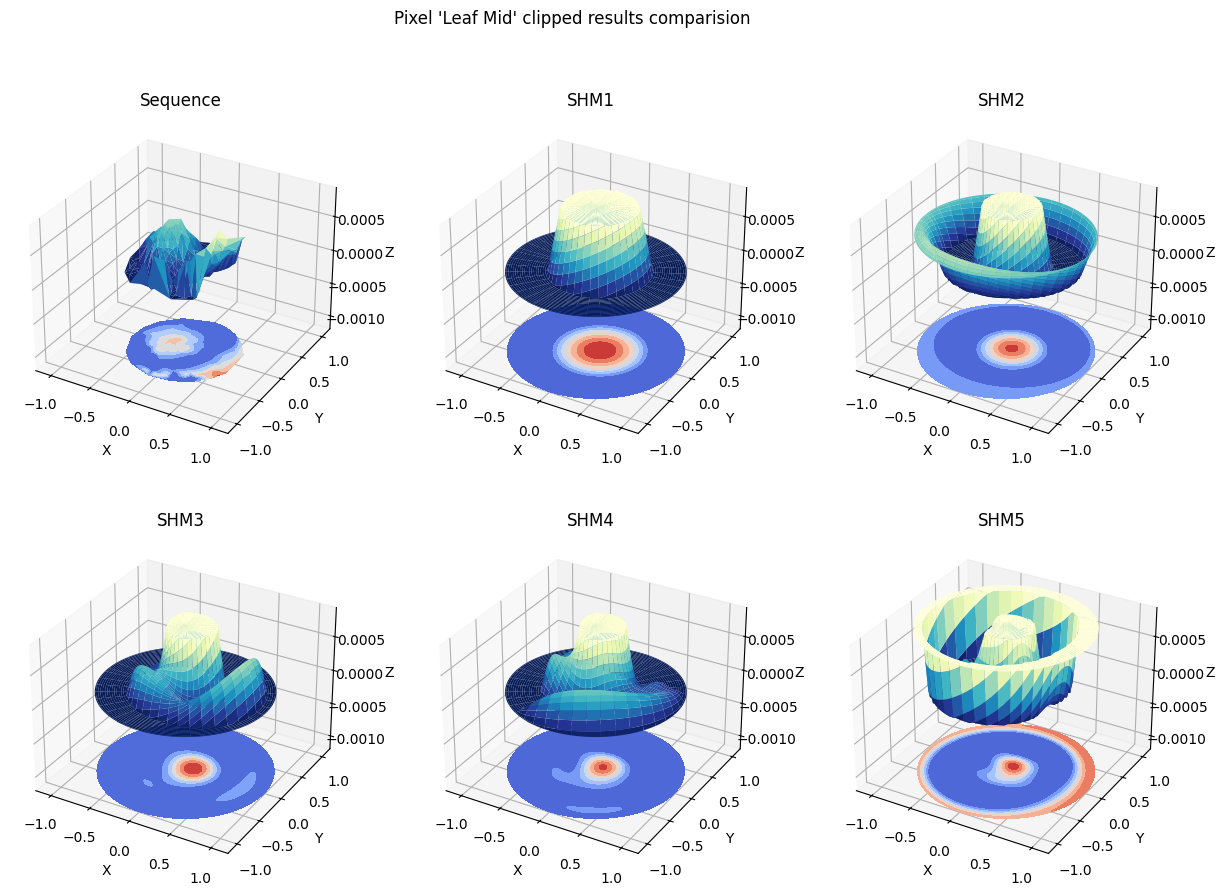

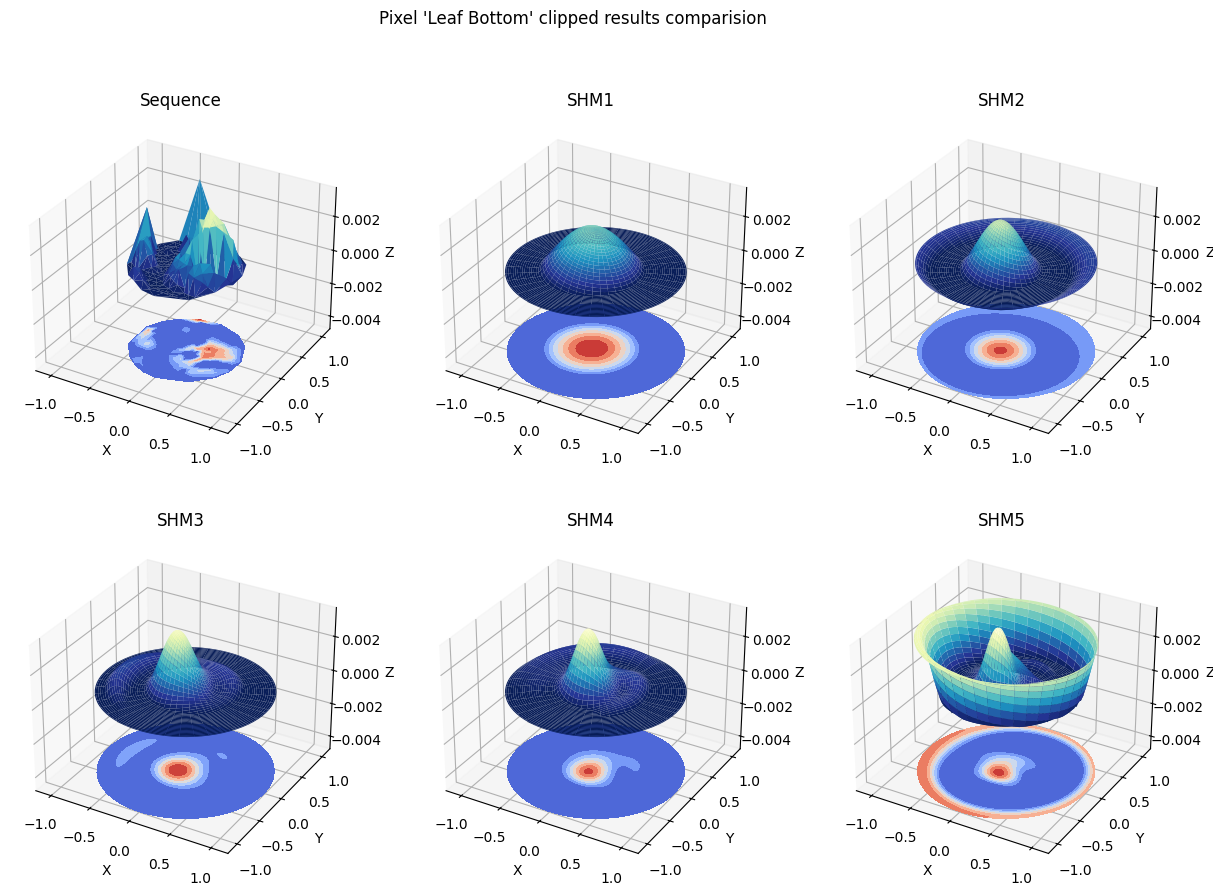

In [8]:
def calcShmPix(coord, coeff):
    #x,y,z = coord
    lat, long = coord
    val = 0
    for i in range(len(coeff)):
        l = math.floor(math.sqrt(i))
        m = i - l * (l + 1)
        # l & m are parameters of the degree of the harmonics in the shape of:
        # (0,0), (1,-1), (1,0), (1,1), (2,-2), (2,-1), ...
        val += scipy.special.sph_harm(m, l, long*np.pi + (pi_by_2 if m < 0 else 0), pi_by_2 - lat*pi_by_2).real * coeff[i]
        
    return val


fitter = SHFitter({})
def shm(coords, *coeffs):
    return fitter.calc(coords, coeffs)

# Input variable pixel values of images and light position
light_data = np.array([lp.getLL() for _, img, lp in LPSEQ], dtype=np.float32)
img_data = np.array([img.getPix(PIXEL_COORDS[0][0]).lum().get() for _, img, lp in LPSEQ], dtype=np.float32)

# Fit!
shm1_data = [curve_fit(shm, light_data, img_data, [img.getPix(PIXEL_COORDS[i][0]).lum().get() for _, img in SEQ.getDataSequence('shm')]) for i in range(len(PIXEL_COORDS))]
shm2_data = [curve_fit(shm, light_data, img_data, [img.getPix(PIXEL_COORDS[i][0]).lum().get() for _, img in SEQ.getDataSequence('shm2')]) for i in range(len(PIXEL_COORDS))]
shm3_data = [curve_fit(shm, light_data, img_data, [img.getPix(PIXEL_COORDS[i][0]).lum().get() for _, img in SEQ.getDataSequence('shm3')]) for i in range(len(PIXEL_COORDS))]
shm4_data = [curve_fit(shm, light_data, img_data, [img.getPix(PIXEL_COORDS[i][0]).lum().get() for _, img in SEQ.getDataSequence('shm4')]) for i in range(len(PIXEL_COORDS))]
shm5_data = [curve_fit(shm, light_data, img_data, [img.getPix(PIXEL_COORDS[i][0]).lum().get() for _, img in SEQ.getDataSequence('shm5')]) for i in range(len(PIXEL_COORDS))]

shm1_coeff = [data[0] for data in shm1_data]
shm2_coeff = [data[0] for data in shm2_data]
shm3_coeff = [data[0] for data in shm3_data]
shm4_coeff = [data[0] for data in shm4_data]
shm5_coeff = [data[0] for data in shm5_data]

# Sample PTM & PTMZ
shm1_clipped = [sampleRtiGridData(lambda coord: calcShmPix(coord, shm1_coeff[i]), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm2_clipped = [sampleRtiGridData(lambda coord: calcShmPix(coord, shm2_coeff[i]), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm3_clipped = [sampleRtiGridData(lambda coord: calcShmPix(coord, shm3_coeff[i]), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm4_clipped = [sampleRtiGridData(lambda coord: calcShmPix(coord, shm4_coeff[i]), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]
shm5_clipped = [sampleRtiGridData(lambda coord: calcShmPix(coord, shm5_coeff[i]), CoordSys.LatLong, PIXEL_ROTATION[i]) for i in range(len(PIXEL_COORDS))]

# Plot
for i in range(len(shm1_clipped)):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10), subplot_kw={'projection': '3d'}) # nrows=1
    fig.suptitle(f"Pixel '{PIXEL_COORDS[i][1]}' clipped results comparision")
    plotPointData(seq_data[i], normalize=False, trisurf_small=True, ax=axs[0][0], title="Sequence")
    max_val = np.max(seq_data[i][2])
    plotGridData(shm1_clipped[i], normalize=max_val, clip=True, ax=axs[0][1], title="SHM1")
    plotGridData(shm2_clipped[i], normalize=max_val, clip=True, ax=axs[0][2], title="SHM2")
    plotGridData(shm3_clipped[i], normalize=max_val, clip=True, ax=axs[1][0], title="SHM3")
    plotGridData(shm4_clipped[i], normalize=max_val, clip=True, ax=axs[1][1], title="SHM4")
    plotGridData(shm5_clipped[i], normalize=max_val, clip=True, ax=axs[1][2], title="SHM5")
#    plt.show()